* Name: YEDLA USHA SRI
* Roll Number: 12041780
* References Used to Complete the Assignment
    * a. https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who
    * b. https://www.geeksforgeeks.org/
    * c. https://www.tutorialspoint.com/
    * d. https://machinelearningmastery.com/rfe-feature-selection-in-python/
    * e. www.statsmodels.org

...


# Part 1: NY Taxi Fare Prediction

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c new-york-city-taxi-fare-prediction

In [ ]:
!unzip new-york-city-taxi-fare-prediction

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
train = pd.read_csv("/content/train.csv", nrows = 1000000)
test = pd.read_csv("/content/test.csv")

PART 1 --> DATA CLEANSING 

Will perform the following activities
1.   Shape of train and test sets
2.   Check for NaNs and drop them (if any)
3.   Check for outliers and drop them (if any)
4.   Type conversion of relevant fields





In [ ]:
train.head()

In [ ]:
# Check no of rows & columns in the dataset
print("Shape of the Training data :", train.shape)

# See all the columns in the dataset
print("All columns are :", list(train.columns))

In [ ]:
# Check datatypes & count of not-null values in each field
train.info()

In [ ]:
#check for missing values in train data
print(train.isnull().sum())

In [ ]:
#check for missing values in test data
print(test.isnull().sum())

In [ ]:
#drop the missing values
train = train.dropna(how='any')

In [ ]:
#check the target column
print(train['fare_amount'].isnull().sum())
print(train.shape)

In [ ]:
#Look for no. of non-positive fare_amount values.
print(train[train['fare_amount']<=0].count())

In [ ]:
# Remove the non-positive fare_amount values.
train = train[train['fare_amount']>0]
print(train.shape)

In [ ]:
#Remove outliers
train = train[train['fare_amount']<275]
train = train[train['fare_amount']>2.5]
train = train[train['passenger_count']<100]
print(train.shape)

**Next let us explore the pickup latitude and longitudes**, 

Googling gave me this info
*   Latitudes range from -90 to 90.
*   Longitudes range from -180 to 180.

The above describe clearly shows some outliers. Let's filter them


Check the data types of each column

In [ ]:
train.shape

In [ ]:
train = train[train['pickup_longitude']>-180]
train = train[train['dropoff_longitude']<180]
train = train[train['pickup_latitude']>-90]
train = train[train['dropoff_latitude']<90]

In [ ]:
train.shape

In [ ]:
train.dtypes

key and pickup_datetime seem to be datetime columns which are in object format. Let's convert them to datetime

In [ ]:
train['key'] = pd.to_datetime(train['key'])
train['pickup_datetime']  = pd.to_datetime(train['pickup_datetime'])

In [ ]:
#Convert for test data
test['key'] = pd.to_datetime(test['key'])
test['pickup_datetime']  = pd.to_datetime(test['pickup_datetime'])

In [ ]:
#check the dtypes after conversion
train.dtypes

In [ ]:
test.dtypes

Now, for **EDA**. The following are my considerations - 
1. Does the number of passengers affect the fare? 
2. Does the date and time of pickup affect the fare?
3. Does the day of the week affect the fare?
4. Does the distance travelled affect the fare?

First, let's split the datetime field 'pickup_datetime' to the following - 
* year
* month
* date
* hour
* day of week

Using these we shall calculate the day of the week and come to our conclusions about how pickup_location affects the fare.
Also, create a new field 'distance' to fetch the distance between the pickup and the drop.

We can calulate the distance in a sphere when latitudes and longitudes are given by [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula)

**haversine(θ) = sin²(θ/2)**

Eventually, the formual boils down to the following where φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,371km) to include latitude and longitude coordinates (A and B in this case).

**a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)**

**c = 2 * atan2( √a, √(1−a) )**

**d = R ⋅ c**

**d = Haversine distance**

*Refer [this](https://community.esri.com/groups/coordinate-reference-systems/blog/2017/10/05/haversine-formula) page for more info and examples on Haversine formula*

Is this distance equal to the road travel distance? Do we have to do something else?


In [ ]:
def haversine_distance(lat1, long1, lat2, long2):
    data = [train, test]
    for i in data:
        R = 6371  #radius of earth in kilometers
        phi1 = np.radians(i[lat1])
        phi2 = np.radians(i[lat2])
    
        delta_phi = np.radians(i[lat2]-i[lat1])
        delta_lambda = np.radians(i[long2]-i[long1])
    
        #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
        a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    
        #c = 2 * atan2( √a, √(1−a) )
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
        #d = R*c
        d = (R * c) #in kilometers
        i['H_Distance'] = d
    return d

In [ ]:
haversine_distance('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

Now that we have calculated the distance, we shall create columns for the following -


*   year
*   month
*   date
*   hour
*   day of week






In [ ]:
data = [train,test]
for i in data:
    i['Year'] = i['pickup_datetime'].dt.year
    i['Month'] = i['pickup_datetime'].dt.month
    i['Date'] = i['pickup_datetime'].dt.day
    i['Day of Week'] = i['pickup_datetime'].dt.dayofweek
    i['Hour'] = i['pickup_datetime'].dt.hour

In [ ]:
train.head()

**1. Does the number of passengers affect the fare?**

In [ ]:
sns.scatterplot(x='passenger_count',y='fare_amount',data=train)

**2. Does the date and time of pickup affect the fare?**

In [ ]:
plt.figure(figsize = (16, 12))
ax = plt.subplot(2,2,1)
sns.scatterplot(x='Year',y='fare_amount',data=train, ax=ax)
ax = plt.subplot(2,2,2)
sns.scatterplot(x='Month',y='fare_amount',data=train, ax=ax)
ax = plt.subplot(2,2,3)
sns.scatterplot(x='Date',y='fare_amount',data=train, ax=ax)
ax = plt.subplot(2,2,4)
sns.scatterplot(x='Hour',y='fare_amount',data=train, ax=ax)

**3. Does the day of the week affect the fare?**

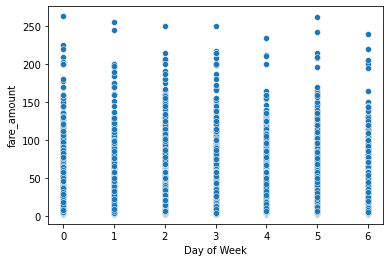

In [ ]:
sns.scatterplot(x='Day of Week',y='fare_amount',data=train)

**4. Does the distance affect the fare?**

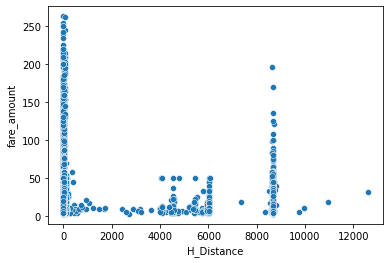

In [ ]:
sns.scatterplot(x='H_Distance',y='fare_amount',data=train)

# Data Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler()

In [ ]:
for col in train:
  if(col!='fare_amount' and col!= 'pickup_datetime'  and col!= 'key'):
    scaling = MinMaxScaler()
    train[col] = scaling.fit_transform(train[[col]])
  else:
    train[col] = train[col]

In [ ]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,Year,Month,Date,Day of Week,Hour
0,2009-06-15 17:26:21.000000100,4.5,2009-06-15 17:26:21+00:00,0.020499,0.042564,0.932288,0.987234,0.166667,0.000082,0.000000,0.454545,0.466667,0.000000,0.739130
1,2010-01-05 16:52:16.000000200,16.9,2010-01-05 16:52:16+00:00,0.020434,0.042560,0.932210,0.987256,0.166667,0.000671,0.166667,0.000000,0.133333,0.166667,0.695652
2,2011-08-18 00:35:00.000000490,5.7,2011-08-18 00:35:00+00:00,0.020447,0.042579,0.932203,0.987246,0.333333,0.000110,0.333333,0.636364,0.566667,0.500000,0.000000
3,2012-04-21 04:30:42.000000100,7.7,2012-04-21 04:30:42+00:00,0.020445,0.042569,0.932203,0.987248,0.166667,0.000222,0.500000,0.272727,0.666667,0.833333,0.173913
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,0.020452,0.042581,0.932223,0.987256,0.166667,0.000159,0.166667,0.181818,0.266667,0.166667,0.304348


# Building a Pipeline

In [ ]:
raw_train = pd.read_csv("/content/train.csv", nrows = 1000000)
raw_test = pd.read_csv("/content/test.csv")

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
class drop_null_values(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.dropna(how='any')

In [ ]:
class remove_outliers(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if('fare_amount' in X.columns):
          X = X[X['fare_amount']>2.5]
          X = X[X['fare_amount']<275]
        X = X[X['passenger_count']<100]
        X = X[(X['pickup_longitude']>-180) & (X['pickup_longitude']<180)]
        X = X[(X['dropoff_longitude']<180) & (X['dropoff_longitude']>-180)]
        X = X[(X['pickup_latitude']>-90) & (X['pickup_latitude']<90)]
        X = X[(X['dropoff_latitude']<90) & (X['dropoff_latitude']>-90)]
        return X

In [ ]:
def haversine_distance(i,lat1, long1, lat2, long2):
          R = 6371  #radius of earth in kilometers
          phi1 = np.radians(i[lat1])
          phi2 = np.radians(i[lat2])
      
          delta_phi = np.radians(i[lat2]-i[lat1])
          delta_lambda = np.radians(i[long2]-i[long1])
        
          #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
          a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
      
          #c = 2 * atan2( √a, √(1−a) )
          c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
      
          #d = R*c
          d = (R * c) #in kilometers
          i['H_Distance'] = d
          return d

In [ ]:
class add_features(BaseEstimator, TransformerMixin):
    def __init__(self, H_distance=True, Year=True, Month=True, Date=True, Day_of_Week=True, Hour=True):
        self.H_distance = H_distance
        self.Year = Year
        self.Month = Month
        self.Date = Date
        self.Day_of_Week = Day_of_Week
        self.Hour = Hour
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
      X['key'] = pd.to_datetime(X['key'])
      X['pickup_datetime']  = pd.to_datetime(X['pickup_datetime'])
      if self.Year:
          X["Year"] = X['pickup_datetime'].dt.year
      if self.Month:
          X["Month"] = X['pickup_datetime'].dt.month
      if self.Date:
          X["Date"] = X['pickup_datetime'].dt.day
      if self.Day_of_Week:
          X["Day_of_Week"] = X['pickup_datetime'].dt.dayofweek
      if self.Hour:
          X["Hour"] = X["pickup_datetime"].dt.hour
      haversine_distance(X,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
      return X

In [ ]:
class scaling(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for col in X:
          if(col!='fare_amount' and col!= 'pickup_datetime'  and col!= 'key'):
            scaling = MinMaxScaler()
            X[col] = scaling.fit_transform(X[[col]])
          else:
            X[col] = X[col]
        return X
    

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

pre_pipe = Pipeline([
    ('dropna', drop_null_values()),
    ('outliers', remove_outliers()),
    ('features', add_features()),
    ('scaling', scaling())
])
pre_pipe_test = Pipeline([
    ('features', add_features()),
    ('scaling', scaling())
])

train_prepared = pre_pipe.fit_transform(raw_train)
test_prepared = pre_pipe_test.fit_transform(raw_test)
raw_piped_train = train_prepared
raw_piped_test = test_prepared

In [ ]:
raw_piped_test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Date,Day_of_Week,Hour,H_Distance
0,2015-01-27 13:08:24.000000200,2015-01-27 13:08:24+00:00,0.220338,0.167776,0.221502,0.155060,0.0,1.000000,0.000000,0.866667,0.166667,0.565217,0.023234
1,2015-01-27 13:08:24.000000300,2015-01-27 13:08:24+00:00,0.209638,0.128686,0.207781,0.150950,0.0,1.000000,0.000000,0.866667,0.166667,0.565217,0.024254
2,2011-10-08 11:53:44.000000200,2011-10-08 11:53:44+00:00,0.213066,0.156736,0.222898,0.157102,0.0,0.333333,0.818182,0.233333,0.833333,0.478261,0.006187
3,2012-12-01 21:12:12.000000200,2012-12-01 21:12:12+00:00,0.214143,0.171297,0.214414,0.161976,0.0,0.500000,1.000000,0.000000,0.833333,0.913043,0.019611
4,2012-12-01 21:12:12.000000300,2012-12-01 21:12:12+00:00,0.226085,0.190628,0.215894,0.155584,0.0,0.500000,1.000000,0.000000,0.833333,0.913043,0.053875


In [ ]:
print(raw_piped_train.isnull().sum())

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
Year                 0
Month                0
Date                 0
Day_of_Week          0
Hour                 0
H_Distance           0
dtype: int64


In [ ]:
raw_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [ ]:
type(raw_piped_train)

pandas.core.frame.DataFrame

In [ ]:
raw_piped_y = raw_piped_train['fare_amount']
raw_piped_train = raw_piped_train.drop(['fare_amount','key','pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis=1)
raw_piped_test = raw_piped_test.drop(['key','pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis=1)
#raw_piped_y.head()
raw_piped_test.head()

,passenger_count,Year,Month,Date,Day_of_Week,Hour,H_Distance
0,0.0,1.000000,0.000000,0.866667,0.166667,0.565217,0.023234
1,0.0,1.000000,0.000000,0.866667,0.166667,0.565217,0.024254
2,0.0,0.333333,0.818182,0.233333,0.833333,0.478261,0.006187
3,0.0,0.500000,1.000000,0.000000,0.833333,0.913043,0.019611
4,0.0,0.500000,1.000000,0.000000,0.833333,0.913043,0.053875


In [ ]:
X_train = raw_piped_train.to_numpy()
X_test = raw_piped_test.to_numpy()
y_train = raw_piped_y.to_numpy()
y_train = np.matrix(y_train).T

In [ ]:
raw_piped_test.shape

(9914, 7)

In [ ]:
type(raw_piped_train)

pandas.core.frame.DataFrame

In [ ]:
raw_piped_train.shape

(995859, 7)

# K-Cross Validation Method

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
linear = LinearRegression()
num_rows, num_cols = X_train.shape
k = 5
fold_size = int(num_rows/k)
fold1 = X_train[:fold_size-1,:]
fold2 = X_train[fold_size:2*fold_size-1,:]
fold3 = X_train[2*fold_size:3*fold_size-1,:]
fold4 = X_train[3*fold_size:4*fold_size-1,:]
fold5 = X_train[4*fold_size:,:]
y_fold1 = y_train[:fold_size-1,0]
y_fold2 = y_train[fold_size:2*fold_size-1,0]
y_fold3 = y_train[2*fold_size:3*fold_size-1,0]
y_fold4 = y_train[3*fold_size:4*fold_size-1,0]
y_fold5 = y_train[4*fold_size:,0]

y_error = []
y_map_error = []
train1 = np.vstack((fold1, fold2, fold3, fold4))
train2 = np.vstack((fold1, fold2, fold3, fold5))
train3 = np.vstack((fold1, fold2, fold4, fold5))
train4 = np.vstack((fold1, fold3, fold4, fold5))
train5 = np.vstack((fold2, fold3, fold4, fold5))
test1 = np.vstack((y_fold1, y_fold2, y_fold3, y_fold4))
test2 = np.vstack((y_fold1, y_fold2, y_fold3, y_fold5))
test3 = np.vstack((y_fold1, y_fold2, y_fold4, y_fold5))
test4 = np.vstack((y_fold1, y_fold3, y_fold4, y_fold5))
test5 = np.vstack((y_fold2, y_fold3, y_fold4, y_fold5))
linear.fit(train1,test1)
y_predict = linear.predict(fold5)
y_error.append(mean_squared_error(y_fold5, y_predict, squared=False))
y_map_error.append(mean_absolute_error(y_fold5, y_predict))
linear.fit(train2,test2)
y_predict = linear.predict(fold4)
y_error.append(mean_squared_error(y_fold4, y_predict, squared=False))
y_map_error.append(mean_absolute_error(y_fold4, y_predict))
linear.fit(train3,test3)
y_predict = linear.predict(fold3)
y_error.append(mean_squared_error(y_fold3, y_predict, squared=False))
y_map_error.append(mean_absolute_error(y_fold3, y_predict))
linear.fit(train4,test4)
y_predict = linear.predict(fold2)
y_error.append(mean_squared_error(y_fold2, y_predict, squared=False))
y_map_error.append(mean_absolute_error(y_fold2, y_predict))
linear.fit(train5,test5)
y_predict = linear.predict(fold1)
y_error.append(mean_squared_error(y_fold1, y_predict, squared=False))
y_map_error.append(mean_absolute_error(y_fold1, y_predict))
a = np.array(y_error)  
b=np.mean(a)  
print("RMSE - ",b)
a_map = np.array(y_map_error)  
b_map = np.mean(a_map)
print("MAP percentage - ",b_map)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.

RMSE -  9.661103125659908
MAP percentage -  5.958848708739962


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.

In [ ]:
rows,columns = y_train.shape
columns

1

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
lasso=Lasso()
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}
lasso_regressor=GridSearchCV(lasso,parameters,scoring='neg_mean_squared_error',cv=5)

lasso_regressor.fit(raw_piped_train,raw_piped_y)
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.767e+05, tolerance: 7.554e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.284e+05, tolerance: 7.535e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

{'alpha': 1e-08}
-93.34012183640716


# Linear Regression 

In [ ]:
#Matrix based linear regression
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
 
regr.fit(X_train, y_train)
print(regr.score(raw_piped_train, raw_piped_y))

y_pred = regr.predict(raw_piped_test)
y_pred

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.016538485880645548


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


array([[12.97850176],
       [12.98885416],
       [11.26623479],
       ...,
       [15.33610955],
       [14.51206914],
       [13.34908582]])

In [ ]:
raw_piped_test.shape

(9914, 7)

The Equation finally obtained will be - 
y_pred.[x0,x1,x2,x3,x4,....] = 12.97*x0 + 12.98*x1.......

In [ ]:
#Optimization based
from sklearn import linear_model
n_samples, n_features = 10, 5
rng = np.random.RandomState(0)
SGDReg =linear_model.SGDRegressor(
   max_iter = 1000,penalty = "elasticnet",loss = 'huber',tol = 1e-3, average = True
)
SGDReg.fit(raw_piped_train, raw_piped_y)
SGDReg.coef_

array([0.75763088, 2.37211848, 1.17903831, 0.75033299, 0.81303056,
       0.85185272, 0.00492432])

In [ ]:
raw_piped_train.head()

,passenger_count,Year,Month,Date,Day_of_Week,Hour,H_Distance
0,0.166667,0.000000,0.454545,0.466667,0.000000,0.739130,0.000082
1,0.166667,0.166667,0.000000,0.133333,0.166667,0.695652,0.000671
2,0.333333,0.333333,0.636364,0.566667,0.500000,0.000000,0.000110
3,0.166667,0.500000,0.272727,0.666667,0.833333,0.173913,0.000222
4,0.166667,0.166667,0.181818,0.266667,0.166667,0.304348,0.000159


In [ ]:
raw_piped_test.head()

,passenger_count,Year,Month,Date,Day_of_Week,Hour,H_Distance
0,0.0,1.000000,0.000000,0.866667,0.166667,0.565217,0.023234
1,0.0,1.000000,0.000000,0.866667,0.166667,0.565217,0.024254
2,0.0,0.333333,0.818182,0.233333,0.833333,0.478261,0.006187
3,0.0,0.500000,1.000000,0.000000,0.833333,0.913043,0.019611
4,0.0,0.500000,1.000000,0.000000,0.833333,0.913043,0.053875


In [ ]:
# Non-parametric
from sklearn.tree import DecisionTreeRegressor 
  
regressor = DecisionTreeRegressor(random_state = 0) 
  
regressor.fit(raw_piped_train, raw_piped_y)
y_pred = regressor.predict(raw_piped_test)
y_pred

array([57.54, 57.54, 49.8 , ..., 11.  ,  9.5 ,  9.5 ])

# Continue in a similar way for each of the parts

# Start of Part 2: Life Expectancy prediction

# Pre-Processing

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"yedlaushasri","key":"c840f2428c49b80fbe1e2c375bd104d2"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d kumarajarshi/life-expectancy-who

life-expectancy-who.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip life-expectancy-who

Archive:  life-expectancy-who.zip
replace Life Expectancy Data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns

from matplotlib import pyplot as plt

In [ ]:
train_data = pd.read_csv("Life Expectancy Data.csv")

In [ ]:
# Check no of rows & columns in the dataset
print("Shape of the Training data :", train_data.shape)

# See all the columns in the dataset
print("All columns are :", list(train_data.columns))

Shape of the Training data : (2938, 22)
All columns are : ['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure', 'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years', ' thinness 5-9 years', 'Income composition of resources', 'Schooling']


In [ ]:
# Check datatypes & count of not-null values in each field
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

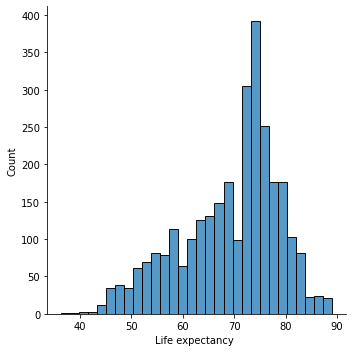

In [ ]:
sns.displot(train_data, x="Life expectancy ")

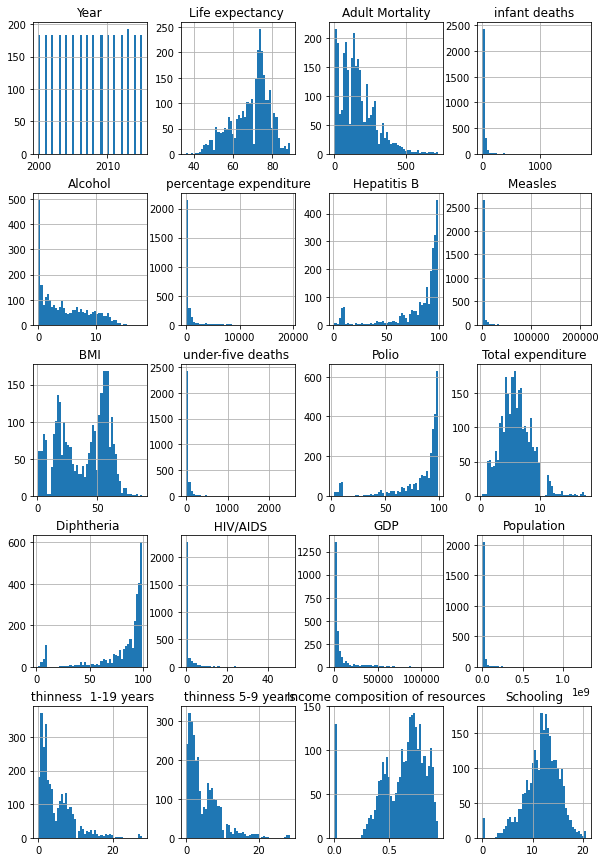

In [ ]:
train_data.hist(bins=50,figsize=((10,15)))
plt.show()

In [ ]:
#check for missing values in train data
print(train_data.isnull().sum())

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64


In [ ]:
train_data['Life expectancy '].fillna(value=train_data['Life expectancy '].mean(),inplace=True)
train_data["Adult Mortality"].fillna(value=train_data['Adult Mortality'].mean(),inplace=True)
train_data['Alcohol'].fillna(value=train_data['Alcohol'].mean(),inplace=True)
train_data['Hepatitis B'].fillna(value=train_data['Hepatitis B'].mean(),inplace=True)
train_data[' BMI '].fillna(value=train_data[' BMI '].mean(),inplace=True)
train_data["Polio"].fillna(value=train_data["Polio"].mean(),inplace=True)
train_data['Total expenditure'].fillna(value=train_data['Total expenditure'].mean(),inplace=True)
train_data['Diphtheria '].fillna(value=train_data['Diphtheria '].mean(),inplace=True)
train_data['GDP'].fillna(value=train_data['GDP'].mean(),inplace=True)
train_data['Population'].fillna(value=train_data['Population'].mean(),inplace=True)
train_data[' thinness  1-19 years'].fillna(value=train_data[' thinness  1-19 years'].mean(),inplace=True)
train_data[' thinness 5-9 years'].fillna(value=train_data[' thinness 5-9 years'].mean(),inplace=True)
train_data['Income composition of resources'].fillna(value=train_data['Income composition of resources'].mean(),inplace=True)
train_data['Schooling'].fillna(value=train_data['Schooling'].mean(),inplace=True)
print(train_data.isnull().sum())

Country                            0
Year                               0
Status                             0
Life expectancy                    0
Adult Mortality                    0
infant deaths                      0
Alcohol                            0
percentage expenditure             0
Hepatitis B                        0
Measles                            0
 BMI                               0
under-five deaths                  0
Polio                              0
Total expenditure                  0
Diphtheria                         0
 HIV/AIDS                          0
GDP                                0
Population                         0
 thinness  1-19 years              0
 thinness 5-9 years                0
Income composition of resources    0
Schooling                          0
dtype: int64


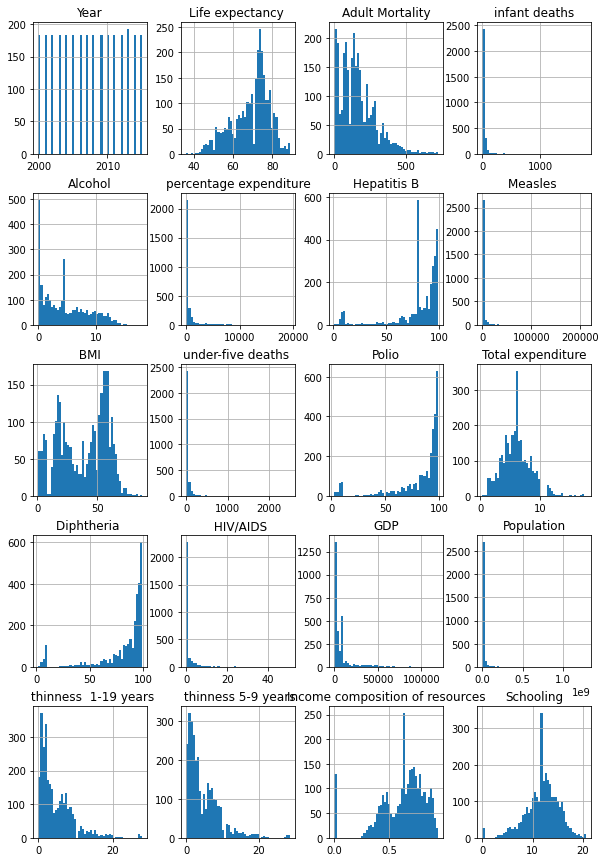

In [ ]:
train_data.hist(bins=50,figsize=((10,15)))
plt.show()

In [ ]:
train_data.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.000000,2938.000000,2938.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.938190,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.507640,124.080302,117.926501,3.916288,1987.914858,22.586855,11467.272489,19.927677,160.445548,23.352143,2.400274,23.640073,5.077785,13136.800417,5.381546e+07,4.394535,4.482708,0.204820,3.264381
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.370000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.200000,74.000000,0.000000,1.092500,4.685343,80.940461,0.000000,19.400000,0.000000,78.000000,4.370000,78.000000,0.100000,580.486996,4.189172e+05,1.600000,1.600000,0.504250,10.300000
50%,2008.000000,72.000000,144.000000,3.000000,4.160000,64.912906,87.000000,17.000000,43.000000,4.000000,93.000000,5.938190,93.000000,0.100000,3116.561755,3.675929e+06,3.400000,3.400000,0.662000,12.100000
75%,2012.000000,75.600000,227.000000,22.000000,7.390000,441.534144,96.000000,360.250000,56.100000,28.000000,97.000000,7.330000,97.000000,0.800000,7483.158469,1.275338e+07,7.100000,7.200000,0.772000,14.100000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.600000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


In [ ]:
train_data = train_data.dropna(axis=0,how='any')

In [ ]:
train_data.shape

(2938, 22)

In [ ]:
train_data.dtypes

Country                             object
Year                                 int64
Status                              object
Life expectancy                    float64
Adult Mortality                    float64
infant deaths                        int64
Alcohol                            float64
percentage expenditure             float64
Hepatitis B                        float64
Measles                              int64
 BMI                               float64
under-five deaths                    int64
Polio                              float64
Total expenditure                  float64
Diphtheria                         float64
 HIV/AIDS                          float64
GDP                                float64
Population                         float64
 thinness  1-19 years              float64
 thinness 5-9 years                float64
Income composition of resources    float64
Schooling                          float64
dtype: object

# Visualization

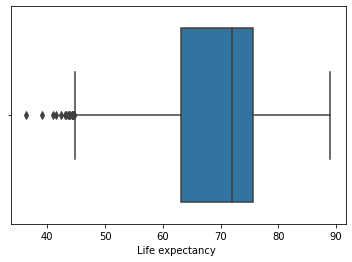

In [ ]:

sns.boxplot(x='Life expectancy ',data=train_data)

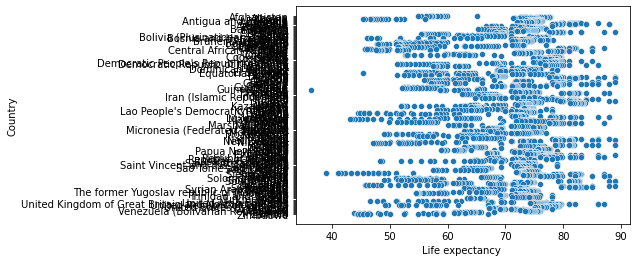

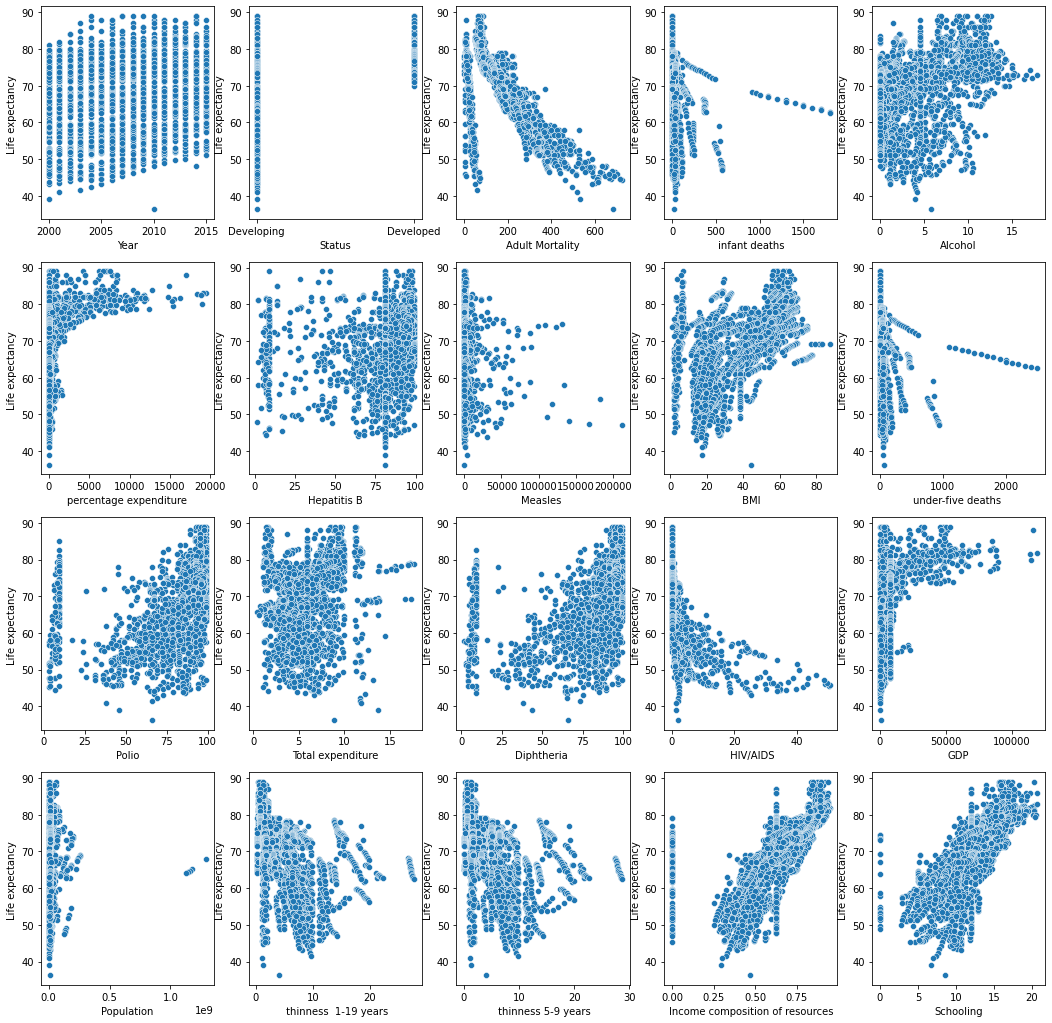

In [ ]:
sns.scatterplot(x='Life expectancy ',y='Country',data=train_data)
plt.figure(figsize = (18, 18))
ax = plt.subplot(4,5,1)
sns.scatterplot(x='Year',y='Life expectancy ',data=train_data, ax=ax)
ax = plt.subplot(4,5,2)
sns.scatterplot(x='Status',y='Life expectancy ',data=train_data, ax=ax)
ax = plt.subplot(4,5,3)
sns.scatterplot(x='Adult Mortality',y='Life expectancy ',data=train_data, ax=ax)
ax = plt.subplot(4,5,4)
sns.scatterplot(x='infant deaths',y='Life expectancy ',data=train_data, ax=ax)
ax = plt.subplot(4,5,5)
sns.scatterplot(x='Alcohol',y='Life expectancy ',data=train_data, ax=ax)
ax = plt.subplot(4,5,6)
sns.scatterplot(x='percentage expenditure',y='Life expectancy ',data=train_data, ax=ax)
ax = plt.subplot(4,5,7)
sns.scatterplot(x='Hepatitis B',y='Life expectancy ',data=train_data, ax=ax)
ax = plt.subplot(4,5,8)
sns.scatterplot(x='Measles ',y='Life expectancy ',data=train_data, ax=ax)
ax = plt.subplot(4,5,9)
sns.scatterplot(x=' BMI ',y='Life expectancy ',data=train_data, ax=ax)
ax = plt.subplot(4,5,10)
sns.scatterplot(x='under-five deaths ',y='Life expectancy ',data=train_data, ax=ax)
ax = plt.subplot(4,5,11)
sns.scatterplot(x='Polio',y='Life expectancy ',data=train_data, ax=ax)
ax = plt.subplot(4,5,12)
sns.scatterplot(x='Total expenditure',y='Life expectancy ',data=train_data, ax=ax)
ax = plt.subplot(4,5,13)
sns.scatterplot(x='Diphtheria ',y='Life expectancy ',data=train_data, ax=ax)
ax = plt.subplot(4,5,14)
sns.scatterplot(x=' HIV/AIDS',y='Life expectancy ',data=train_data, ax=ax)
ax = plt.subplot(4,5,15)
sns.scatterplot(x='GDP',y='Life expectancy ',data=train_data, ax=ax)
ax = plt.subplot(4,5,16)
sns.scatterplot(x='Population',y='Life expectancy ',data=train_data, ax=ax)
ax = plt.subplot(4,5,17)
sns.scatterplot(x=' thinness  1-19 years',y='Life expectancy ',data=train_data, ax=ax)
ax = plt.subplot(4,5,18)
sns.scatterplot(x=' thinness 5-9 years',y='Life expectancy ',data=train_data, ax=ax)
ax = plt.subplot(4,5,19)
sns.scatterplot(x='Income composition of resources',y='Life expectancy ',data=train_data, ax=ax)
ax = plt.subplot(4,5,20)
sns.scatterplot(x='Schooling',y='Life expectancy ',data=train_data, ax=ax)


In [ ]:
import plotly.express as px
fig = px.choropleth(train_data, locations='Country',locationmode="country names",color=' BMI ')
fig.show()

In [ ]:
value = "infant deaths"
fig = px.choropleth(                        
        data_frame=train_data,
        locations='Country',
        locationmode='country names',
        color=value,
        animation_frame="Year",
        animation_group="Country")
fig.update_layout(title = value  + " in different years")
fig.show()

In [ ]:
value = "Life expectancy "
fig = px.choropleth(                        
        data_frame=train_data,
        locations='Country',
        locationmode='country names',
        color=value,
        animation_frame="Year",
        animation_group="Country")
fig.update_layout(title = value  + " in different years")
fig.show()

In [ ]:
value = "Schooling"
fig = px.choropleth(                        
        data_frame=train_data,
        locations='Country',
        locationmode='country names',
        color=value,
        animation_frame="Year",
        animation_group="Country")
fig.update_layout(title = value  + " in different years")
fig.show()

# Data Distribution

In [ ]:
new_train_data = train_data.drop(['Country','Status'],axis=1)

In [ ]:
from scipy.stats import kstest
for i in new_train_data.columns:
  x = kstest(new_train_data[i], "norm")
  print(x)

KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=0.9918427500282746, pvalue=0.0)
KstestResult(statistic=0.5722124276161502, pvalue=0.0)
KstestResult(statistic=0.6397660548769124, pvalue=0.0)
KstestResult(statistic=0.765922478906687, pvalue=0.0)
KstestResult(statistic=0.998266490773143, pvalue=0.0)
KstestResult(statistic=0.607270290107641, pvalue=0.0)
KstestResult(statistic=0.9811967335850476, pvalue=0.0)
KstestResult(statistic=0.58718860188436, pvalue=0.0)
KstestResult(statistic=0.9986501019683699, pvalue=0.0)
KstestResult(statistic=0.9316014702046477, pvalue=0.0)
KstestResult(statistic=0.9983097343713652, pvalue=0.0)
KstestResult(statistic=0.539827837277029, pvalue=0.0)
KstestResult(statistic=0.9995457064126058, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=0.7174694720519473, pvalue=0.0)
KstestResult(statistic=0.7115725583007069, pvalue=0.0)
KstestResult(statistic=0.5660792291875301, pvalue=0.0)
Kstest

# Data Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
scaling_data = StandardScaler()
for col in train_data:
  if(col!='Status' and col!= 'Country'):
    scaling_data = StandardScaler()
    train_data[col] = scaling_data.fit_transform(train_data[[col]])
  else:
    train_data[col] = train_data[col]

In [ ]:
train_data.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,1.621762,Developing,-0.444448,0.791586,0.268824,-1.172958,-0.335570,-0.705861,-0.110384,...,-3.278638,0.925806,-0.732952,-0.323445,-0.525248,0.389975,2.813130,2.773279,-0.725401,-0.579931
1,Afghanistan,1.404986,Developing,-0.980950,0.856072,0.285786,-1.172958,-0.334441,-0.838704,-0.168124,...,-1.051482,0.934140,-0.859877,-0.323445,-0.523083,-0.230936,2.881408,2.817902,-0.740050,-0.610570
2,Afghanistan,1.188210,Developing,-0.980950,0.831890,0.302749,-1.172958,-0.334594,-0.750142,-0.173531,...,-0.880163,0.913306,-0.775260,-0.323445,-0.521632,0.352715,2.926927,2.862526,-0.769349,-0.641209
3,Afghanistan,0.971434,Developing,-1.023029,0.864132,0.328193,-1.172958,-0.332096,-0.617299,0.032045,...,-0.666013,1.075815,-0.648335,-0.323445,-0.518723,-0.168315,2.972446,2.929461,-0.803531,-0.671847
4,Afghanistan,0.754658,Developing,-1.054587,0.888314,0.345155,-1.172958,-0.367862,-0.573018,0.051757,...,-0.623183,0.804966,-0.606027,-0.323445,-0.564893,-0.181666,3.040724,2.974085,-0.847480,-0.763764


# Building a Pipeline

In [ ]:
raw_data = pd.read_csv("Life Expectancy Data.csv")

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
class fill_median(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X.fillna(value=X['Life expectancy '].mean(),inplace=True)
        X.fillna(value=X['Adult Mortality'].mean(),inplace=True)
        X.fillna(value=X['Alcohol'].mean(),inplace=True)
        X.fillna(value=X['Hepatitis B'].mean(),inplace=True)
        X.fillna(value=X[' BMI '].mean(),inplace=True)
        X.fillna(value=X["Polio"].mean(),inplace=True)
        X.fillna(value=X['Total expenditure'].mean(),inplace=True)
        X.fillna(value=X['Diphtheria '].mean(),inplace=True)
        X.fillna(value=X['GDP'].mean(),inplace=True)
        X.fillna(value=X['Population'].mean(),inplace=True)
        X.fillna(value=X[' thinness  1-19 years'].mean(),inplace=True)
        X.fillna(value=X[' thinness 5-9 years'].mean(),inplace=True)
        X.fillna(value=X['Income composition of resources'].mean(),inplace=True)
        X.fillna(value=X['Schooling'].mean(),inplace=True)
        return X


In [ ]:
class scaling(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for col in X:
          if(col!='Status' and col!= 'Country'):
            scaling = StandardScaler()
            X[col] = scaling.fit_transform(X[[col]])
          else:
            X[col] = X[col]
        return X

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pre_pipe = Pipeline([
    ('dropna', fill_median()),
    ('scaling', scaling())
])
train_prepared = pre_pipe.fit_transform(raw_data)
raw_piped_train = train_prepared

In [ ]:
raw_piped_train.shape
print(train_data.isnull().sum())

Country                            0
Year                               0
Status                             0
Life expectancy                    0
Adult Mortality                    0
infant deaths                      0
Alcohol                            0
percentage expenditure             0
Hepatitis B                        0
Measles                            0
 BMI                               0
under-five deaths                  0
Polio                              0
Total expenditure                  0
Diphtheria                         0
 HIV/AIDS                          0
GDP                                0
Population                         0
 thinness  1-19 years              0
 thinness 5-9 years                0
Income composition of resources    0
Schooling                          0
dtype: int64


In [ ]:
raw_piped_train_y = raw_piped_train['Life expectancy ']
raw_piped_train = raw_piped_train.drop(['Life expectancy ','Country','Status'],axis=1)

In [ ]:
raw_piped_train_y.shape

(2938,)

In [ ]:
X_train = raw_piped_train.to_numpy()
y_train = raw_piped_train_y.to_numpy()
y_train = np.matrix(y_train).T

# Cross Validation

In [ ]:
from sklearn.model_selection import KFold


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
linear = LinearRegression()
num_rows, num_cols = X_train.shape
k = 5
fold_size = int(num_rows/k)
fold1 = X_train[:fold_size-1,:]
fold2 = X_train[fold_size:2*fold_size-1,:]
fold3 = X_train[2*fold_size:3*fold_size-1,:]
fold4 = X_train[3*fold_size:4*fold_size-1,:]
fold5 = X_train[4*fold_size:,:]
y_fold1 = y_train[:fold_size-1,0]
y_fold2 = y_train[fold_size:2*fold_size-1,0]
y_fold3 = y_train[2*fold_size:3*fold_size-1,0]
y_fold4 = y_train[3*fold_size:4*fold_size-1,0]
y_fold5 = y_train[4*fold_size:,0]

y_error = []
y_map_error = []
train1 = np.vstack((fold1, fold2, fold3, fold4))
train2 = np.vstack((fold1, fold2, fold3, fold5))
train3 = np.vstack((fold1, fold2, fold4, fold5))
train4 = np.vstack((fold1, fold3, fold4, fold5))
train5 = np.vstack((fold2, fold3, fold4, fold5))
test1 = np.vstack((y_fold1, y_fold2, y_fold3, y_fold4))
test2 = np.vstack((y_fold1, y_fold2, y_fold3, y_fold5))
test3 = np.vstack((y_fold1, y_fold2, y_fold4, y_fold5))
test4 = np.vstack((y_fold1, y_fold3, y_fold4, y_fold5))
test5 = np.vstack((y_fold2, y_fold3, y_fold4, y_fold5))
linear.fit(train1,test1)
y_predict = linear.predict(fold5)
y_error.append(mean_squared_error(y_fold5, y_predict, squared=False))
y_map_error.append(mean_absolute_error(y_fold5, y_predict))
linear.fit(train2,test2)
y_predict = linear.predict(fold4)
y_error.append(mean_squared_error(y_fold4, y_predict, squared=False))
y_map_error.append(mean_absolute_error(y_fold4, y_predict))
linear.fit(train3,test3)
y_predict = linear.predict(fold3)
y_error.append(mean_squared_error(y_fold3, y_predict, squared=False))
y_map_error.append(mean_absolute_error(y_fold3, y_predict))
linear.fit(train4,test4)
y_predict = linear.predict(fold2)
y_error.append(mean_squared_error(y_fold2, y_predict, squared=False))
y_map_error.append(mean_absolute_error(y_fold2, y_predict))
linear.fit(train5,test5)
y_predict = linear.predict(fold1)
y_error.append(mean_squared_error(y_fold1, y_predict, squared=False))
y_map_error.append(mean_absolute_error(y_fold1, y_predict))
a = np.array(y_error)  
b=np.mean(a)  
print("RMSE - ",b)
a_map = np.array(y_map_error)  
b_map = np.mean(a_map)  
print("MAP - ",b_map)

RMSE -  0.49618497423968205
MAP -  0.3645798335462499


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.

# Feature Selection

## Lasso

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
lasso=Lasso()
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1e-1,1,5,10]}
lasso_regressor=GridSearchCV(lasso,parameters,scoring='neg_mean_squared_error',cv=5)
lasso_regressor.fit(raw_piped_train,raw_piped_train_y)
print(lasso_regressor.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.548e+02, tolerance: 2.238e-01

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.600e+02, tolerance: 2.401e-01

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.547e+02, tolerance: 2.416e-01

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent

{'alpha': 0.001}


In [ ]:
from sklearn.linear_model import Lasso
X = raw_piped_train
Y = raw_piped_train_y
names = ['Year','Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure', 'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years', ' thinness 5-9 years', 'Income composition of resources', 'Schooling']
def lasso(alphas):
    '''
    Takes in a list of alphas. Outputs a dataframe containing the coefficients of lasso regressions from each alpha.
    '''
    df = pd.DataFrame()

    df['Feature Name'] = names
    
    for alpha in alphas:

        lasso = Lasso(alpha=alpha) 
        lasso.fit(X, Y)
        column_name = 'Alpha = %f' % alpha
        df[column_name] = lasso.coef_  
    return df
lasso([1e-15,.0001, .5, 10])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.181e+02, tolerance: 2.938e-01

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.083e+01, tolerance: 2.938e-01



,Feature Name,Alpha = 0.000000,Alpha = 0.000100,Alpha = 0.500000,Alpha = 10.000000
0,Year,0.017188,0.017161,0.000000,0.0
1,Adult Mortality,-0.302403,-0.302683,-0.195659,-0.0
2,infant deaths,1.360075,1.328128,-0.000000,-0.0
3,Alcohol,0.096529,0.095751,0.000000,0.0
4,percentage expenditure,0.045334,0.045352,0.000000,0.0
5,Hepatitis B,-0.042981,-0.042917,0.000000,0.0
6,Measles,-0.026871,-0.026979,-0.000000,-0.0
7,BMI,0.166581,0.166696,0.000000,0.0
8,under-five deaths,-1.389611,-1.357624,-0.000000,-0.0
9,Polio,0.086967,0.087196,0.000000,0.0


## OLS

In [ ]:
import statsmodels.api as sm

result = sm.OLS(raw_piped_train_y, raw_piped_train).fit()
# to get summary
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:       Life expectancy    R-squared (uncentered):                   0.783
Model:                            OLS   Adj. R-squared (uncentered):              0.782
Method:                 Least Squares   F-statistic:                              555.8
Date:                Sun, 11 Sep 2022   Prob (F-statistic):                        0.00
Time:                        04:16:57   Log-Likelihood:                         -1921.4
No. Observations:                2938   AIC:                                      3881.
Df Residuals:                    2919   BIC:                                      3995.
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------

In [ ]:
raw_piped_train.shape


(2938, 19)

## RFE

In [ ]:
X_new = raw_piped_train
y_new = raw_piped_train_y
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
estimator = RandomForestRegressor(n_estimators=100,max_depth=10)
selector = RFE(estimator, n_features_to_select=10)
selector = selector.fit(X_new, y_new)
arr = selector.ranking_
arr

array([ 1,  1,  5,  2,  8, 10,  9,  1,  1,  1,  4,  6,  1,  3,  7,  1,  1,
        1,  1])

In [ ]:
for i in range(len(arr)):
  print(arr[i],":" ,X_new.columns[i])

1 : Year
1 : Adult Mortality
5 : infant deaths
2 : Alcohol
8 : percentage expenditure
10 : Hepatitis B
9 : Measles 
1 :  BMI 
1 : under-five deaths 
1 : Polio
4 : Total expenditure
6 : Diphtheria 
1 :  HIV/AIDS
3 : GDP
7 : Population
1 :  thinness  1-19 years
1 :  thinness 5-9 years
1 : Income composition of resources
1 : Schooling


# Questions

A.  Feature Selection: Do various predicting factors which have been chosen initially really affect the 
Life expectancy? What are the predicting variables actually affecting life expectancy?

Ans - Yes, they really affect the Life expectancy.

      Below is the ranking of the attributes - 
      
      1 : Year
      1 : Adult Mortality
      5 : infant deaths
      1 : Alcohol
      4 : percentage expenditure
      10 : Hepatitis B
      8 : Measles 
      1 :  BMI 
      1 : under-five deaths 
      1 : Polio
      2 : Total expenditure
      6 : Diphtheria 
      1 :  HIV/AIDS
      9 : GDP
      7 : Population
      3 :  thinness  1-19 years
      1 :  thinness 5-9 years
      1 : Income composition of resources
      1 : Schooling

B.  Should a country having a lower life expectancy value (<65) increase its healthcare expenditure in 
order to improve its average lifespan?

Ans - Yes, it can improve average lifespan with increase in healtcare expenditure. We can see from the scatterplot of percentage expenditure vs Life expentancy that age<65 are only seen in very lower percentage expenditure. So they can increase their Life expentancy with percentage expenditure.

C.  How do Infant and Adult mortality rates affect life expectancy?

Ans - The countires with low Adult mortality rate are having high Life expectancy and the countires with high Adult mortality rate are having low Life expectancy 

D.  Does Life Expectancy have positive or negative correlation with eating habits, lifestyle, exercise, 
smoking, drinking alcohol etc.

Ans - From the data of graphs, alcohol has not much effect on Life expectancy, it is distributed uniformly(maybe because of the data) . But actually Life expectancy will have positive correlation with eating habits, lifestyle, exercise, less smoking, less drinking alcohol etc.

E.  What is the impact of schooling on the lifespan of humans?

Ans - As the countries having hish education levels have high Life expectancy.

F.  Does Life Expectancy have a positive or negative relationship with drinking alcohol?

Ans - It is negatively correlated with alcohol consumption. But in the graph it looks like uniformly destibuted.

G.  Do densely populated countries tend to have lower life expectancy?

Ans - Most of the countries have less population(i.e less than 20lakhs) and the Life expectancy of these countries does not depend on population much(it is uniformly distributed). Around 10-15 countries in the dataset have Life expectany around 60-70 years.

H.  What is the impact of Immunization coverage on life Expectancy?

Ans - It is positively correlated with life Expectancy.